In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/AAPL_Validation.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/FB_Validation.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/TSLA_Validation.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/MSFT_Validation.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/MSFT_Test.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/TSLA_Test.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/FB_Test.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/AAPL_Test.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/FB_Train.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/MSFT_Train.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/AAPL_Train.csv
/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/TSLA_Train.csv


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define the paths to the data files
train_paths = [
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/AAPL_Train.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/FB_Train.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/MSFT_Train.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Train/TSLA_Train.csv'
]

val_paths = [
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/AAPL_Validation.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/FB_Validation.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/MSFT_Validation.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Val/TSLA_Validation.csv'
]

test_paths = [
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/AAPL_Test.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/FB_Test.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/MSFT_Test.csv',
    '/kaggle/input/stock-price-prediction/Stock Price Prediction/Test/TSLA_Test.csv'
]

# Load the data
train_data = [pd.read_csv(path) for path in train_paths]
val_data = [pd.read_csv(path) for path in val_paths]
test_data = [pd.read_csv(path) for path in test_paths]

# Combine the data for each set
train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

# Display the shape of each combined dataset
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (13708, 8)
Validation shape: (2938, 8)
Test shape: (2940, 8)


In [3]:
# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
val_df['Date'] = pd.to_datetime(val_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract date features
for df in [train_df, val_df, test_df]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

# Drop the original Date column and OpenInt (since it's all zeros)
for df in [train_df, val_df, test_df]:
    df.drop(['Date', 'OpenInt'], axis=1, inplace=True)

# One-hot encode the Stock column
train_df = pd.get_dummies(train_df, columns=['Stock'], prefix='Stock')
val_df = pd.get_dummies(val_df, columns=['Stock'], prefix='Stock')
test_df = pd.get_dummies(test_df, columns=['Stock'], prefix='Stock')

# Ensure all datasets have the same columns after one-hot encoding
# Get the union of all columns
all_columns = set(train_df.columns) | set(val_df.columns) | set(test_df.columns)

# Add missing columns to each dataframe with default value 0
for col in all_columns:
    if col not in train_df.columns:
        train_df[col] = 0
    if col not in val_df.columns:
        val_df[col] = 0
    if col not in test_df.columns:
        test_df[col] = 0

# Ensure consistent column order
train_df = train_df[sorted(train_df.columns)]
val_df = val_df[sorted(val_df.columns)]
test_df = test_df[sorted(test_df.columns)]

# Display the preprocessed data
print("Preprocessed train data head:")
print(train_df.head())

Preprocessed train data head:
     Close  Day  DayOfWeek     High      Low  Month     Open  Stock_AAPL  \
0  0.42388    7          4  0.42902  0.41874      9  0.42388        True   
1  0.42134   10          0  0.42516  0.41366      9  0.42388        True   
2  0.42902   11          1  0.43668  0.42516      9  0.42516        True   
3  0.41618   12          2  0.43157  0.41618      9  0.42902        True   
4  0.43927   13          3  0.44052  0.43927      9  0.43927        True   

   Stock_FB  Stock_MSFT  Stock_TSLA    Volume  Year  
0     False       False       False  23220030  1984  
1     False       False       False  18022532  1984  
2     False       False       False  42498199  1984  
3     False       False       False  37125801  1984  
4     False       False       False  57822062  1984  


In [4]:
# Define the target variable (Close price)
target = 'Close'

# Define features (all columns except the target)
features = [col for col in train_df.columns if col != target]

# Split the data into features and target
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]
y_test = test_df[target]

print("Features:", features)
print("Target:", target)

# Display the shapes of the feature and target arrays
print("\nShapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Features: ['Day', 'DayOfWeek', 'High', 'Low', 'Month', 'Open', 'Stock_AAPL', 'Stock_FB', 'Stock_MSFT', 'Stock_TSLA', 'Volume', 'Year']
Target: Close

Shapes:
X_train: (13708, 12)
y_train: (13708,)
X_val: (2938, 12)
y_val: (2938,)
X_test: (2940, 12)
y_test: (2940,)


In [5]:
# Bayesian Regression doesn't strictly require feature scaling, but it's good practice
scaler = StandardScaler()

# Fit the scaler on the training data and transform all datasets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Display the first few rows of the scaled training data
print("Scaled training data (first 5 rows):")
print(X_train_scaled[:5])

Scaled training data (first 5 rows):
[[-1.00025282  1.41487114 -0.45911533 -0.4595331   0.71450372 -0.45929246
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.75567318 -1.72895493]
 [-0.65705148 -1.43933637 -0.459203   -0.45965249  0.71450372 -0.45929246
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.82174646 -1.72895493]
 [-0.54265103 -0.72578449 -0.45894134 -0.45938222  0.71450372 -0.4592629
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.51059912 -1.72895493]
 [-0.42825058 -0.01223262 -0.45905741 -0.45959327  0.71450372 -0.45917377
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.57889582 -1.72895493]
 [-0.31385013  0.70131926 -0.45885412 -0.45905061  0.71450372 -0.45893707
   1.15829475 -0.27534029 -0.82956455 -0.32368367 -0.31579424 -1.72895493]]


In [6]:
# Initialize the Bayesian Ridge Regression model
bayesian_ridge = BayesianRidge()

# Train the model
print("Training Bayesian Ridge Regression model...")
bayesian_ridge.fit(X_train_scaled, y_train)
print("Model trained successfully!")

# Print model parameters
print("\nModel Parameters:")
print(f"Alpha: {bayesian_ridge.alpha_:.4f}")
print(f"Lambda: {bayesian_ridge.lambda_:.4f}")
print(f"Number of iterations: {bayesian_ridge.n_iter_}")

Training Bayesian Ridge Regression model...
Model trained successfully!

Model Parameters:
Alpha: 4.7064
Lambda: 0.0040
Number of iterations: 5


In [7]:
# Make predictions on the validation set
y_val_pred = bayesian_ridge.predict(X_val_scaled)

# Display the first few predictions
print("First 10 predictions on validation set:")
print(y_val_pred[:10])

# Compare with actual values
print("\nActual values for the first 10 samples:")
print(y_val.values[:10])

# Calculate evaluation metrics
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print("Validation Set Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

First 10 predictions on validation set:
[22.4494966  21.99085973 22.85936393 23.53128437 23.28581013 23.13196009
 23.04615032 23.66953677 24.21740982 24.61113998]

Actual values for the first 10 samples:
[22.097 22.387 23.08  23.6   23.335 22.908 23.027 23.755 24.327 24.883]
Validation Set Evaluation:
Mean Absolute Error (MAE): 0.3189
Mean Squared Error (MSE): 0.4800
Root Mean Squared Error (RMSE): 0.6928
R² Score: 0.9999


In [8]:
# Manual hyperparameter tuning with a focused set of parameters
print("Performing manual hyperparameter tuning...")

# Define a focused set of parameters to test
param_combinations = [
    {'alpha_1': 1e-6, 'alpha_2': 1e-6, 'lambda_1': 1e-6, 'lambda_2': 1e-6, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': True},
    {'alpha_1': 1e-5, 'alpha_2': 1e-5, 'lambda_1': 1e-5, 'lambda_2': 1e-5, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': True},
    {'alpha_1': 1e-4, 'alpha_2': 1e-4, 'lambda_1': 1e-4, 'lambda_2': 1e-4, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': True},
    {'alpha_1': 1e-6, 'alpha_2': 1e-6, 'lambda_1': 1e-6, 'lambda_2': 1e-6, 'alpha_init': 1.0, 'lambda_init': 1.0, 'fit_intercept': True},
    {'alpha_1': 1e-6, 'alpha_2': 1e-6, 'lambda_1': 1e-6, 'lambda_2': 1e-6, 'alpha_init': 0.1, 'lambda_init': 0.1, 'fit_intercept': True},
    {'alpha_1': 1e-6, 'alpha_2': 1e-6, 'lambda_1': 1e-6, 'lambda_2': 1e-6, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': False},
    {'alpha_1': 1e-5, 'alpha_2': 1e-5, 'lambda_1': 1e-5, 'lambda_2': 1e-5, 'alpha_init': 1.0, 'lambda_init': 1.0, 'fit_intercept': True},
    {'alpha_1': 1e-4, 'alpha_2': 1e-4, 'lambda_1': 1e-4, 'lambda_2': 1e-4, 'alpha_init': 0.1, 'lambda_init': 0.1, 'fit_intercept': True}
]

best_score = float('inf')
best_params = None

# Test each parameter combination
for i, params in enumerate(param_combinations):
    print(f"\nTesting combination {i+1}/{len(param_combinations)}: {params}")
    
    # Create and train the model
    model = BayesianRidge(**params)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val_scaled)
    
    # Calculate MSE
    mse = mean_squared_error(y_val, y_pred)
    print(f"MSE: {mse:.4f}")
    
    # Update best parameters if this combination is better
    if mse < best_score:
        best_score = mse
        best_params = params

print("\nBest parameters:", best_params)
print("Best MSE score:", best_score)

Performing manual hyperparameter tuning...

Testing combination 1/8: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': True}
MSE: 0.4800

Testing combination 2/8: {'alpha_1': 1e-05, 'alpha_2': 1e-05, 'lambda_1': 1e-05, 'lambda_2': 1e-05, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': True}
MSE: 0.4800

Testing combination 3/8: {'alpha_1': 0.0001, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 0.0001, 'alpha_init': None, 'lambda_init': None, 'fit_intercept': True}
MSE: 0.4800

Testing combination 4/8: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'alpha_init': 1.0, 'lambda_init': 1.0, 'fit_intercept': True}
MSE: 0.4800

Testing combination 5/8: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'alpha_init': 0.1, 'lambda_init': 0.1, 'fit_intercept': True}
MSE: 0.4800

Testing combination 6/8: {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'lambda_1

In [9]:
# Train the model with the best parameters
best_bayesian_ridge = BayesianRidge(**best_params)

print("Training tuned Bayesian Ridge Regression model...")
best_bayesian_ridge.fit(X_train_scaled, y_train)
print("Tuned model trained successfully!")

# Print model parameters
print("\nTuned Model Parameters:")
print(f"Alpha: {best_bayesian_ridge.alpha_:.4f}")
print(f"Lambda: {best_bayesian_ridge.lambda_:.4f}")
print(f"Number of iterations: {best_bayesian_ridge.n_iter_}")

Training tuned Bayesian Ridge Regression model...
Tuned model trained successfully!

Tuned Model Parameters:
Alpha: 4.7064
Lambda: 0.0040
Number of iterations: 5


In [10]:
# Make predictions on the validation set with the tuned model
y_val_pred_tuned = best_bayesian_ridge.predict(X_val_scaled)

# Display the first few predictions
print("First 10 predictions on validation set (tuned model):")
print(y_val_pred_tuned[:10])

# Compare with actual values
print("\nActual values for the first 10 samples:")
print(y_val.values[:10])
# Calculate evaluation metrics
mae_tuned = mean_absolute_error(y_val, y_val_pred_tuned)
mse_tuned = mean_squared_error(y_val, y_val_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_val, y_val_pred_tuned)

print("Validation Set Evaluation (Tuned Model):")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R² Score: {r2_tuned:.4f}")

# Compare with the initial model
print("\nComparison with Initial Model:")
print(f"MAE Improvement: {mae - mae_tuned:.4f}")
print(f"MSE Improvement: {mse - mse_tuned:.4f}")
print(f"RMSE Improvement: {rmse - rmse_tuned:.4f}")
print(f"R² Improvement: {r2_tuned - r2:.4f}")

First 10 predictions on validation set (tuned model):
[22.4494966  21.99085973 22.85936393 23.53128437 23.28581013 23.13196009
 23.04615032 23.66953677 24.21740982 24.61113998]

Actual values for the first 10 samples:
[22.097 22.387 23.08  23.6   23.335 22.908 23.027 23.755 24.327 24.883]
Validation Set Evaluation (Tuned Model):
Mean Absolute Error (MAE): 0.3189
Mean Squared Error (MSE): 0.4800
Root Mean Squared Error (RMSE): 0.6928
R² Score: 0.9999

Comparison with Initial Model:
MAE Improvement: 0.0000
MSE Improvement: 0.0000
RMSE Improvement: 0.0000
R² Improvement: 0.0000


In [11]:
# Make predictions on the test set
y_test_pred = best_bayesian_ridge.predict(X_test_scaled)

# Display the first few predictions
print("First 10 predictions on test set:")
print(y_test_pred[:10])

# Compare with actual values
print("\nActual values for the first 10 samples:")
print(y_test.values[:10])

First 10 predictions on test set:
[72.53863557 72.21568554 72.43580713 73.27625301 75.60448975 75.29645498
 74.93107428 76.12573131 75.5404233  75.96112431]

Actual values for the first 10 samples:
[73.09  72.47  72.569 73.837 76.166 75.553 75.314 76.145 75.619 75.734]


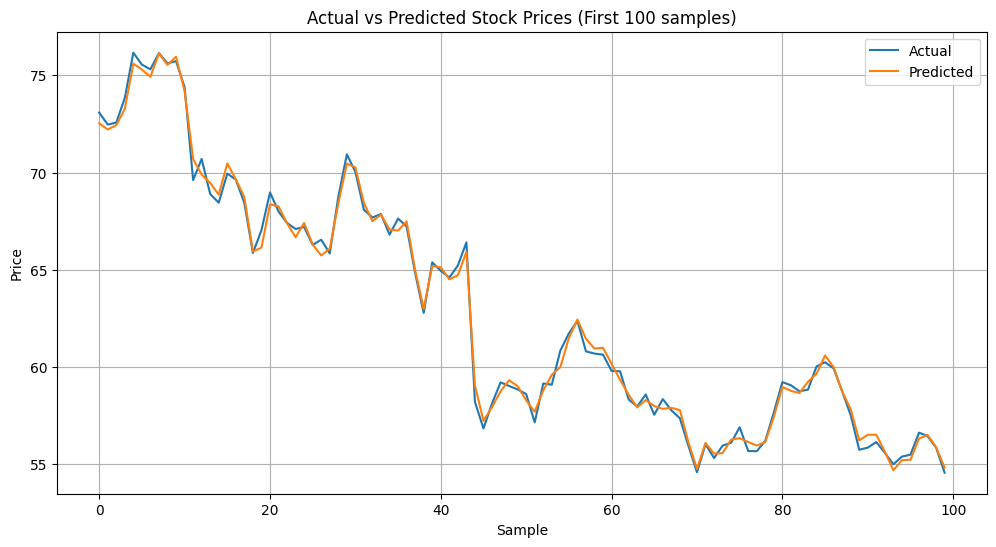

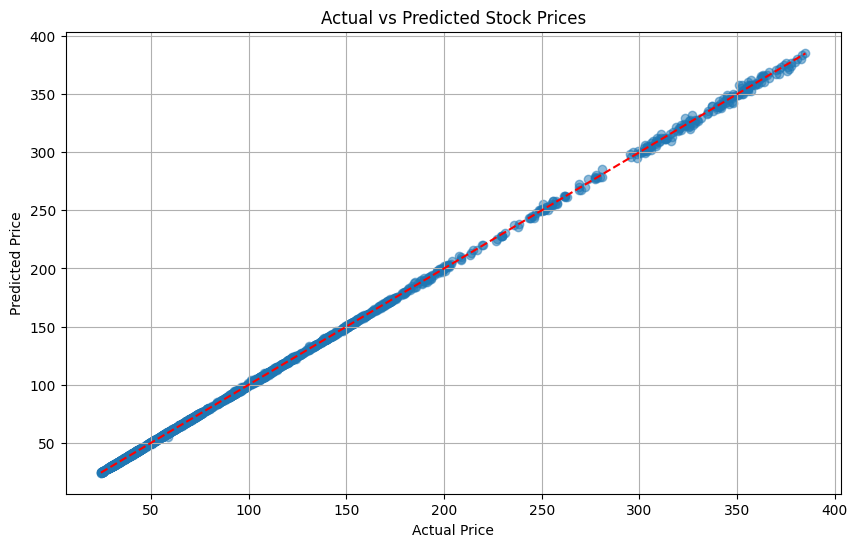

In [12]:
# Plot actual vs predicted values for a subset of the test data
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_test_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Stock Prices (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

In [13]:
# Create a function to evaluate performance by stock
def evaluate_by_stock(X, y_true, y_pred, df):
    # Get the stock columns
    stock_cols = [col for col in df.columns if col.startswith('Stock_')]
    
    # For each stock, find the indices where it's active
    results = {}
    for col in stock_cols:
        stock_name = col.replace('Stock_', '')
        stock_indices = np.where(df[col] == 1)[0]
        
        if len(stock_indices) > 0:
            stock_y_true = y_true[stock_indices]
            stock_y_pred = y_pred[stock_indices]
            
            mae = mean_absolute_error(stock_y_true, stock_y_pred)
            mse = mean_squared_error(stock_y_true, stock_y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(stock_y_true, stock_y_pred)
            
            results[stock_name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'Samples': len(stock_indices)
            }
    
    return results

# Evaluate performance by stock on the test set
test_results_by_stock = evaluate_by_stock(X_test, y_test.values, y_test_pred, test_df)

# Display the results
print("Test Set Performance by Stock:")
for stock, metrics in test_results_by_stock.items():
    print(f"\n{stock}:")
    print(f"  Samples: {metrics['Samples']}")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R2']:.4f}")

Test Set Performance by Stock:

AAPL:
  Samples: 1255
  MAE: 0.3716
  MSE: 0.2441
  RMSE: 0.4941
  R²: 0.9997

FB:
  Samples: 208
  MAE: 0.5233
  MSE: 0.4128
  RMSE: 0.6425
  R²: 0.9982

MSFT:
  Samples: 1198
  MAE: 0.1777
  MSE: 0.0631
  RMSE: 0.2511
  R²: 0.9997

TSLA:
  Samples: 279
  MAE: 1.6968
  MSE: 4.6118
  RMSE: 2.1475
  R²: 0.9988


Feature Importance:
       Feature  Coefficient   Std Dev
2         High    36.270129  0.229479
3          Low    29.953974  0.224460
5         Open   -22.915157  0.261098
4        Month     0.003927  0.003948
9   Stock_TSLA    -0.003811  5.789406
7     Stock_FB     0.003603  5.057300
10      Volume    -0.002628  0.004461
0          Day    -0.002134  0.003937
6   Stock_AAPL     0.001665  9.774241
8   Stock_MSFT    -0.001280  9.709960


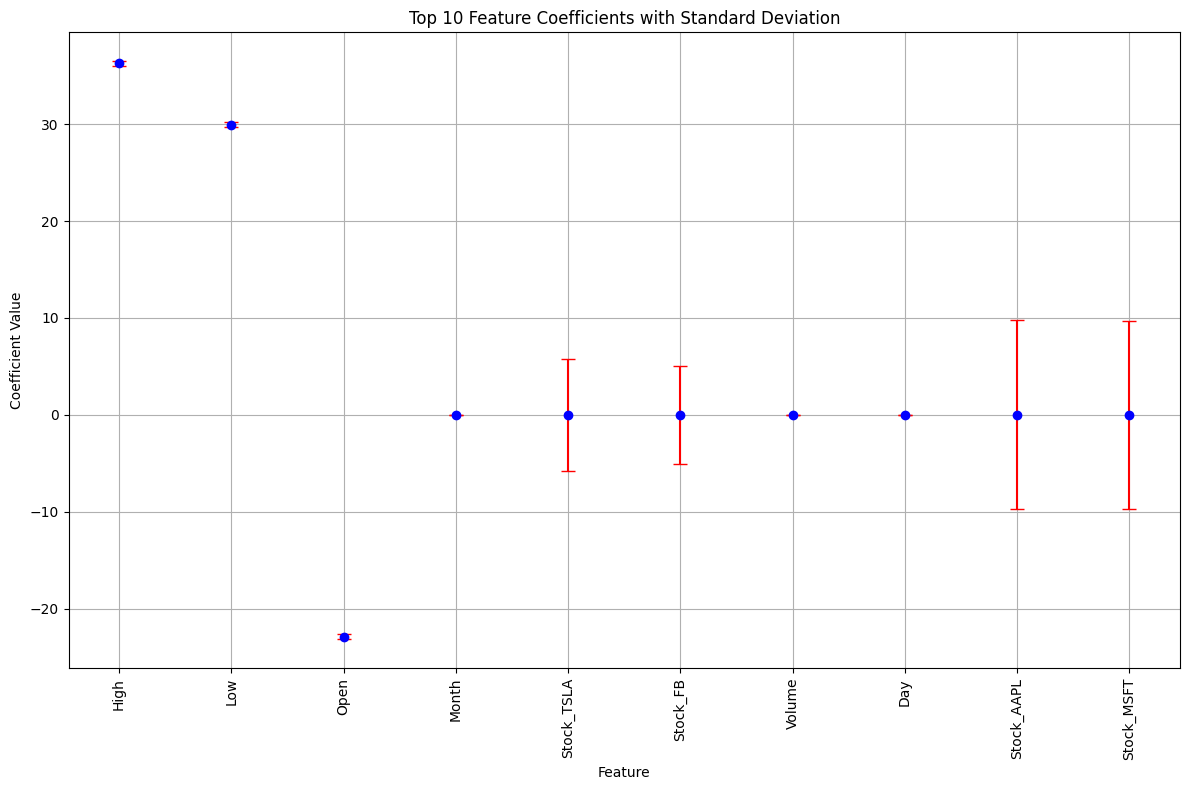

In [14]:
# Get feature coefficients and their standard deviations
coefficients = best_bayesian_ridge.coef_
std_dev = np.sqrt(best_bayesian_ridge.sigma_).diagonal()

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Std Dev': std_dev,
    'Abs Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Abs Coefficient', ascending=False)

# Display feature importance
print("Feature Importance:")
print(feature_importance[['Feature', 'Coefficient', 'Std Dev']].head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.errorbar(feature_importance['Feature'][:10], 
             feature_importance['Coefficient'][:10], 
             yerr=feature_importance['Std Dev'][:10],
             fmt='o', color='blue', ecolor='red', capsize=5)
plt.title('Top 10 Feature Coefficients with Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

Predictions with Uncertainty (First 10 samples):
   Actual  Predicted   Std Dev  Lower Bound  Upper Bound
0  73.090  72.538636  0.461385    71.634321    73.442950
1  72.470  72.215686  0.461247    71.311642    73.119729
2  72.569  72.435807  0.461207    71.531841    73.339773
3  73.837  73.276253  0.461261    72.372182    74.180324
4  76.166  75.604490  0.461271    74.700399    76.508581
5  75.553  75.296455  0.461254    74.392397    76.200513
6  75.314  74.931074  0.461225    74.027073    75.835076
7  76.145  76.125731  0.461259    75.221664    77.029799
8  75.619  75.540423  0.461312    74.636252    76.444594
9  75.734  75.961124  0.461312    75.056952    76.865296


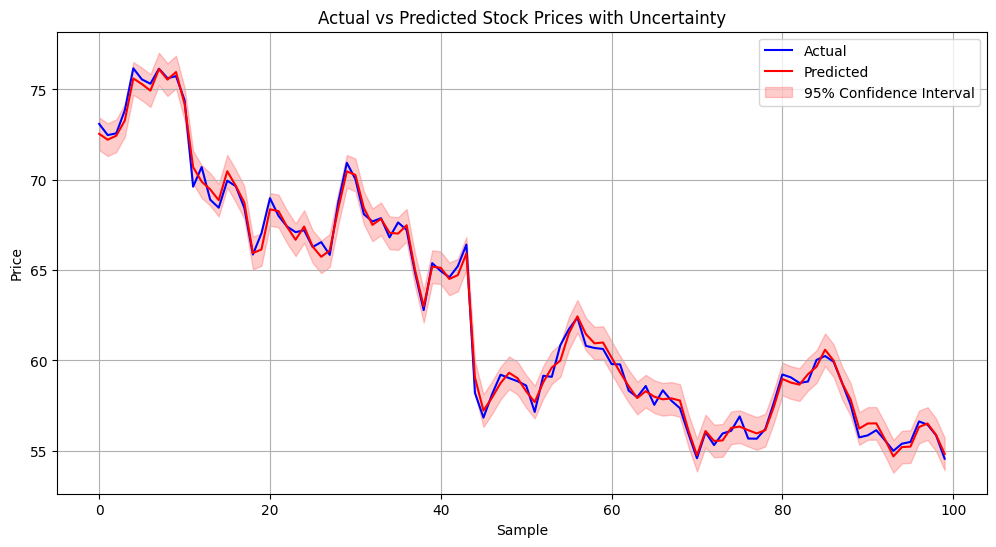

In [15]:
# Get the standard deviation of predictions
_, y_std = best_bayesian_ridge.predict(X_test_scaled, return_std=True)

# Create a DataFrame with predictions and uncertainty
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Std Dev': y_std,
    'Lower Bound': y_test_pred - 1.96 * y_std,  # 95% confidence interval
    'Upper Bound': y_test_pred + 1.96 * y_std
})

# Display the first 10 predictions with uncertainty
print("Predictions with Uncertainty (First 10 samples):")
print(predictions_df.head(10))

# Plot predictions with uncertainty intervals
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['Actual'][:100].values, label='Actual', color='blue')
plt.plot(predictions_df['Predicted'][:100].values, label='Predicted', color='red')
plt.fill_between(
    range(100),
    predictions_df['Lower Bound'][:100].values,
    predictions_df['Upper Bound'][:100].values,
    color='red', alpha=0.2, label='95% Confidence Interval'
)
plt.title('Actual vs Predicted Stock Prices with Uncertainty')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import joblib

# Save the model
model_path = '/kaggle/working/bayesian_ridge_stock_prediction_model.pkl'
joblib.dump(best_bayesian_ridge, model_path)
print(f"Model saved to {model_path}")

# Save the scaler
scaler_path = '/kaggle/working/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Model saved to /kaggle/working/bayesian_ridge_stock_prediction_model.pkl
Scaler saved to /kaggle/working/scaler.pkl
